# ONNX Resize: Antialiasing filter support

In this example we will try to show the need for ONNX Resize operator to support antialiasing filtering capabilities, so that it can be used to replicate the results of some popular data processing toolkits.

We will use an checkerboard-like input to show the differences between different interpolation modes:

Dimensions:  (22, 22, 3)


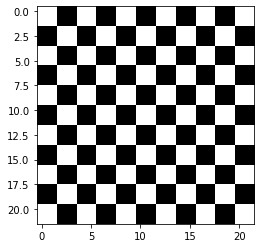

In [38]:
import numpy as np  # type: ignore
import PIL.Image as Image
import cv2

checkerboard = np.array([[1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
                         [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],], dtype=np.uint8)
checkerboard = np.stack([checkerboard, checkerboard, checkerboard], axis=2)*255

# display images in the notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

def show_images(images, titles=[]):
    import matplotlib.gridspec as gridspec
    import matplotlib.pyplot as plt
    columns = 3
    nimages = len(images)
    rows = (nimages + 1) // (columns)
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        if len(titles) > 0:
            plt.title(titles[j])
        plt.imshow(images[j])
    plt.show()

def diff_image(a, b, scale = 1):
    return np.clip((a.astype(np.float32) - b)*scale + 128, 0, 255).astype(np.uint8)

def show_diff(a, b, scale = 1):
    diff = diff_image(a, b, scale=scale)
    plt.imshow(diff.astype(np.uint8))
    diff.shape
    diff2 = diff-128.0
    print(f"Mean diff {np.mean(np.abs(diff2))}, max diff {np.max(diff2)}")
    

plt.imshow(checkerboard)
print("Dimensions: ", checkerboard.shape)

Here's a modified version of the ONNX reference code used for resize tests, including the necessary extensions to implement antialiasing filter capabilities for linear and cubic interpolations

In [39]:
from typing import Any, List, Callable, Union, Optional, Text

def cartesian(arrays: List[np.ndarray], out: np.ndarray = None) -> np.ndarray:
    """
    From https://stackoverflow.com/a/1235363
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n // arrays[0].size
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j * m:(j + 1) * m, 1:] = out[0:m, 1:]
    return out

def interpolate_1d_with_x(data: np.ndarray,
                          scale_factor: float,
                          x: float,
                          get_coeffs: Callable[..., np.ndarray],
                          roi: np.ndarray = None,
                          extrapolation_value: float = 0.0,
                          coordinate_transformation_mode: Text = 'half_pixel',
                          exclude_outside: bool = False,
                          antialias: bool = False,
                          ) -> np.ndarray:
    def get_neighbor_idxes(x: float, n: int, limit: int) -> np.ndarray:
        """
        Return the n nearest indexes to x among [0, limit), prefer the indexes smaller than x.
        As a result, the ratio must be in (0, 1]
        Examples:
        get_neighbor_idxes(4, 2, 10) == [3, 4]
        get_neighbor_idxes(4, 3, 10) == [3, 4, 5]
        get_neighbor_idxes(4.4, 3, 10) == [3, 4, 5]
        get_neighbor_idxes(4.5, 3, 10) == [3, 4, 5]
        get_neighbor_idxes(4.6, 3, 10) == [4, 5, 6]
        get_neighbor_idxes(4.4, 1, 10) == [4]
        get_neighbor_idxes(4.6, 1, 10) == [5]
        :param x:
        :param n: the number of the wanted indexes
        :param limit: the maximum value of index
        :return: An np.array containing n nearest indexes in ascending order
        """
        idxes = sorted(range(limit), key=lambda idx: (abs(x - idx), idx))[:n]
        idxes = sorted(idxes)
        return np.array(idxes)

    def get_neighbor(x: float, n: int, data: np.ndarray) -> np.ndarray:
        """
        Pad `data` in 'edge' mode, and get n nearest elements in the padded array and their indexes in the original
        array
        :param x: center index (in the unpadded coordinate system) of the found nearest elements.
        :param n: the number of neighbors.
        :param data: the array
        :return: A tuple containing the indexes of neighbor elements (the index can be smaller than 0 or higher than
        len(data)) and the value of these elements
        """
        pad_width = np.ceil(n / 2).astype(int)
        padded = np.pad(data, pad_width, mode='edge')
        x += pad_width

        idxes = get_neighbor_idxes(x, n, len(padded))
        ret = padded[idxes]
        return idxes - pad_width, ret

    input_width = len(data)
    output_width = scale_factor * input_width
 
    if coordinate_transformation_mode == 'align_corners':
        if output_width == 1:
            x_ori = 0.
        else:
            x_ori = x * (input_width - 1) / (output_width - 1)
    elif coordinate_transformation_mode == 'asymmetric':
        x_ori = x / scale_factor
    elif coordinate_transformation_mode == 'tf_crop_and_resize':
        if output_width == 1:
            x_ori = (roi[1] - roi[0]) * (input_width - 1) / 2
        else:
            x_ori = x * (roi[1] - roi[0]) * \
                (input_width - 1) / (output_width - 1)
        x_ori += (roi[0] * (input_width - 1))
        # Return extrapolation_value directly as what TF CropAndResize does
        if x_ori < 0 or x_ori > input_width - 1:
            return extrapolation_value
    elif coordinate_transformation_mode == 'pytorch_half_pixel':
        if output_width == 1:
            x_ori = -0.5
        else:
            x_ori = (x + 0.5) / scale_factor - 0.5
    elif coordinate_transformation_mode == 'half_pixel':
        x_ori = (x + 0.5) / scale_factor - 0.5
    else:
        raise ValueError(f'invalid coordinate_transformation_mode: {coordinate_transformation_mode}')
    x_ori_int = np.floor(x_ori).astype(int).item()

    # ratio must be in (0, 1] since we prefer the pixel on the left of `x_ori`
    if x_ori.is_integer():
        ratio = 1
    else:
        ratio = x_ori - x_ori_int

    coeffs = get_coeffs(ratio, scale_factor) if antialias else get_coeffs(ratio)
    #print(f"Ratio={ratio}, coeffs={coeffs}")
    n = len(coeffs)

    idxes, points = get_neighbor(x_ori, n, data)

    if exclude_outside:
        for i, idx in enumerate(idxes):
            if idx < 0 or idx >= input_width:
                coeffs[i] = 0
        coeffs /= sum(coeffs)

    return np.dot(coeffs, points).item()


def interpolate_nd_with_x(data: np.ndarray,
                          n: int,
                          scale_factors: List[float],
                          x: List[float],
                          get_coeffs: Callable[..., np.ndarray],
                          roi: np.ndarray = None,
                          **kwargs: Any
                          ) -> np.ndarray:
    if n == 1:
        return interpolate_1d_with_x(data, scale_factors[0], x[0], get_coeffs, roi=roi,
                                     **kwargs)
    return interpolate_1d_with_x(
        [interpolate_nd_with_x(data[i], n - 1, scale_factors[1:], x[1:], get_coeffs,
                               roi=None if roi is None else np.concatenate(
                                   [roi[1:n], roi[n + 1:]]),
                               **kwargs)
         for i in range(data.shape[0])], scale_factors[0], x[0], get_coeffs,
        roi=None if roi is None else [roi[0], roi[n]], **kwargs)


def interpolate_nd(data: np.ndarray,
                   get_coeffs: Callable[..., np.ndarray],
                   output_size: Optional[List[int]] = None,
                   scale_factors: Optional[List[float]] = None,
                   roi: np.ndarray = None,
                   **kwargs: Any
                   ) -> np.ndarray:
    def get_all_coords(data: np.ndarray) -> np.ndarray:
        return cartesian([list(range(data.shape[i])) for i in range(len(data.shape))])

    assert output_size is not None or scale_factors is not None
    if output_size is not None:
        scale_factors = np.array(output_size) / np.array(data.shape)
    else:
        output_size = (scale_factors * np.array(data.shape)).astype(int)
    assert scale_factors is not None

    ret = np.zeros(output_size)
    for x in get_all_coords(ret):
        ret[tuple(x)] = interpolate_nd_with_x(data, len(data.shape), scale_factors, x, get_coeffs, roi=roi,
                                              **kwargs)
    return ret

def cubic_coeffs(ratio: float, A: float = -0.75) -> np.ndarray:
    assert(ratio >= 0 and ratio <= 1)
    coeffs = [((A * (ratio + 1) - 5 * A) * (ratio + 1) + 8 * A) * (ratio + 1) - 4 * A,
              ((A + 2) * ratio - (A + 3)) * ratio * ratio + 1,
              ((A + 2) * (1 - ratio) - (A + 3)) * (1 - ratio) * (1 - ratio) + 1,
              ((A * ((1 - ratio) + 1) - 5 * A) * ((1 - ratio) + 1) + 8 * A) * ((1 - ratio) + 1) - 4 * A]
    return np.array(coeffs)

def cubic_coeffs_antialias(ratio: float, scale: float, A: float = -0.5) -> np.ndarray:
    if scale > 1.0:  # Antialias is applied when downsampling
        scale = 1.0
    def W(x):
        x = abs(x)
        x_2 = x * x
        x_3 = x * x_2
        if x <= 1:
            return (A + 2) * x_3 - (A + 3) * x_2 + 1
        elif x > 1 and x < 2:
            return A * x_3 - 5*A * x_2 + 8*A * x - 4*A
        else:
            return 0.0
    i_start = int(np.floor(-2 / scale) + 1)
    i_end = 2 - i_start
    args = [scale * (i - ratio) for i in range(i_start, i_end)]
    coeffs = [W(x) for x in args]
    return np.array(coeffs) / sum(coeffs)

def linear_coeffs(ratio: float) -> np.ndarray:
    return np.array([1 - ratio, ratio])

def linear_coeffs_antialias(ratio: float, scale: float) -> np.ndarray:
    if scale > 1.0:  # Antialias is applied when downsampling
        scale = 1.0
    start = int(np.floor(-1 / scale) + 1)
    footprint = 2 - 2 * start
    args = (np.arange(start, start + footprint) - ratio) * scale
    coeffs = np.clip(1 - np.abs(args), 0, 1)
    return np.array(coeffs) / sum(coeffs)


In [40]:
data = checkerboard
data_f = checkerboard.astype(np.float32)
scales = np.array([0.8, 0.6, 1.0], dtype=np.float32)
out_size = (scales * np.array(data_f.shape)).astype(int).tolist()
scales = np.array(out_size) / np.array(data_f.shape)
print("Output dimensions: ", out_size)

out_size_xy = tuple(out_size[1::-1])  # Format expected by PIL

Output dimensions:  [17, 13, 3]


## ONNX Linear vs. PIL vs. OpenCV

In [48]:
linear_onnx = interpolate_nd(
    data_f, linear_coeffs, output_size=out_size).astype(np.uint8)
linear_pil = np.array(Image.fromarray(data).resize(out_size_xy, Image.BILINEAR))
linear_opencv = cv2.resize(data, out_size_xy, interpolation=cv2.INTER_LINEAR)

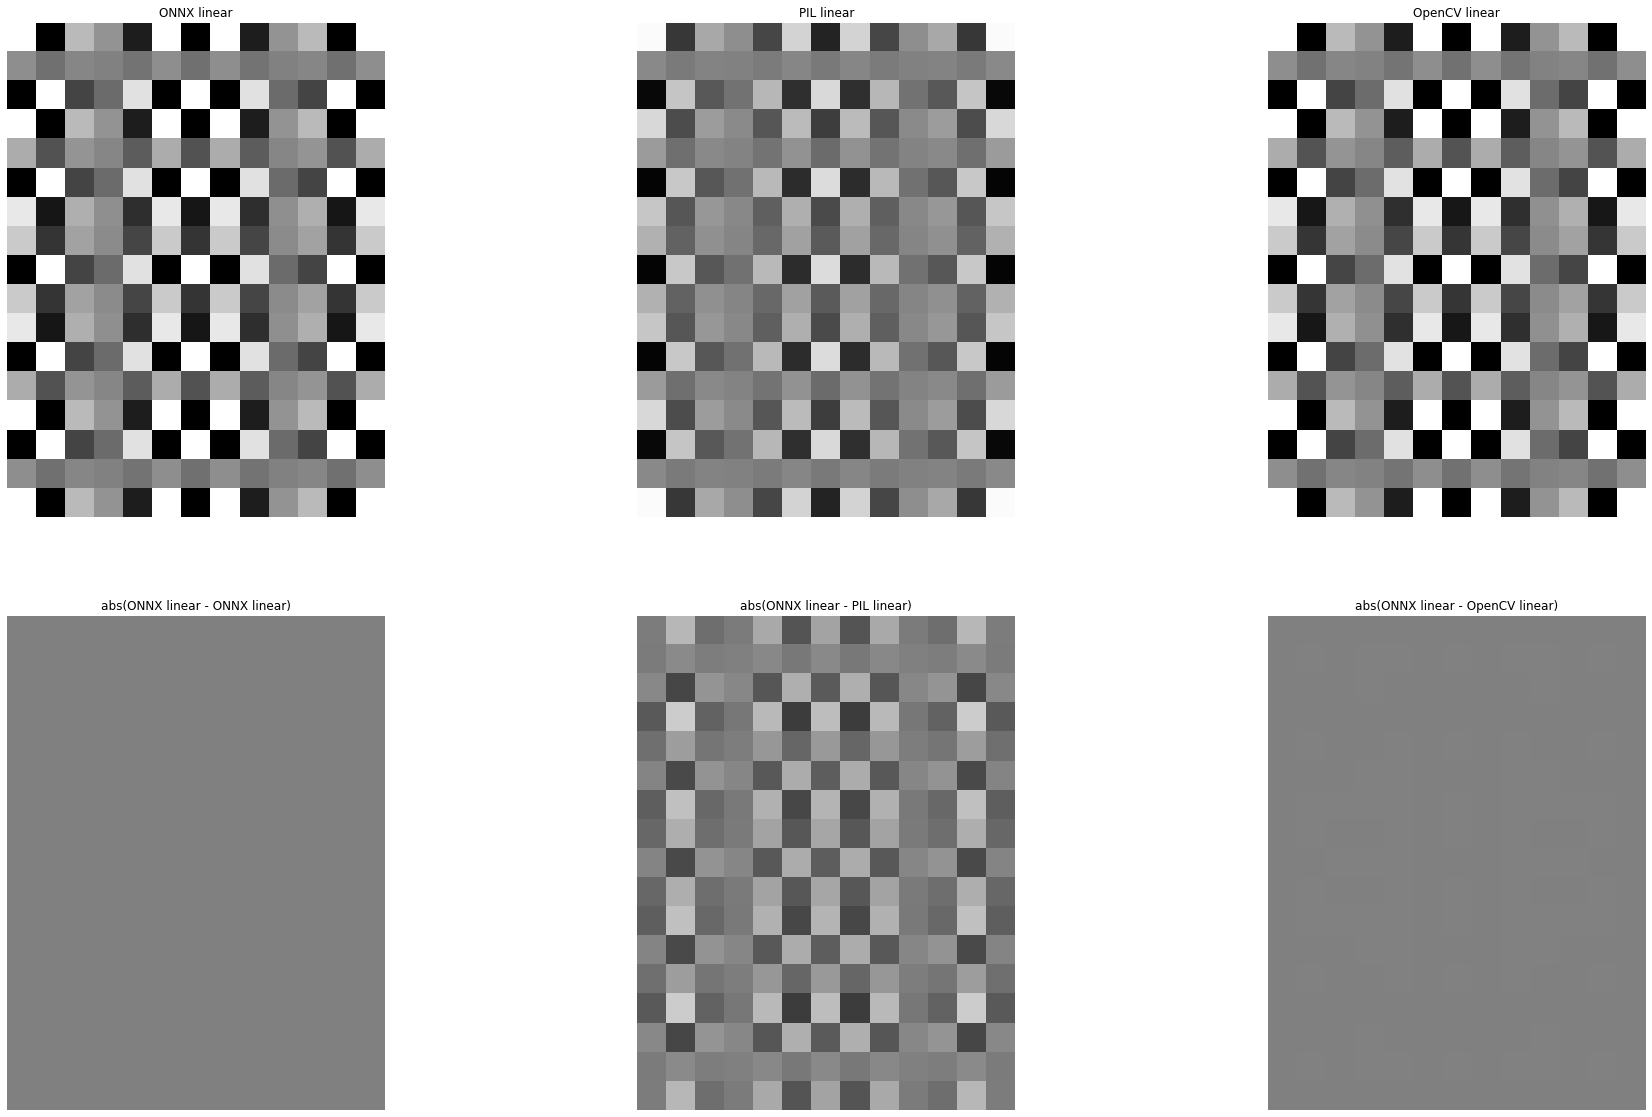

In [49]:
images = [linear_onnx.astype(np.uint8), linear_pil, linear_opencv]
titles = ["ONNX linear", "PIL linear", "OpenCV linear"]
diff_titles = [f"abs({titles[0]} - {t})" for t in titles]
diffs = []

b = images[0]
for a in images:
    diffs.append(diff_image(a, b))

show_images(images + diffs, titles=titles+diff_titles)

## ONNX Linear with antialiasing vs. PIL vs. OpenCV

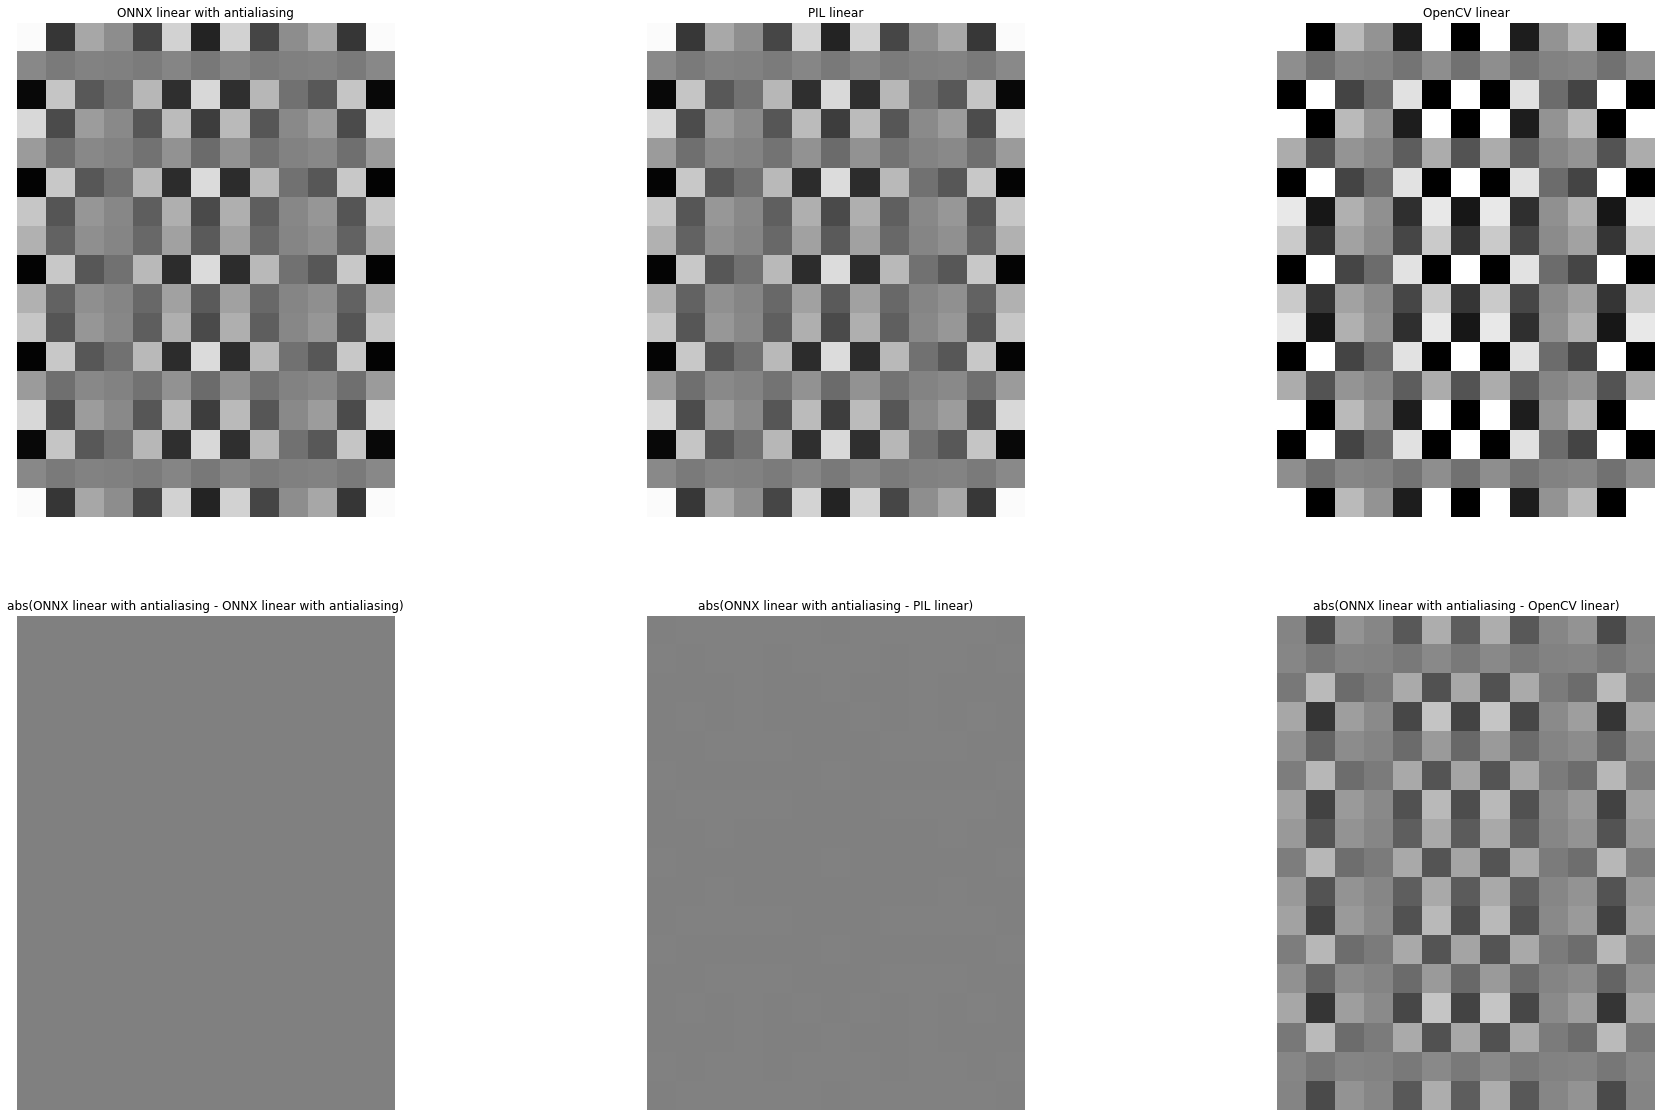

In [50]:
linear_onnx_antialias = interpolate_nd(
    data_f, linear_coeffs_antialias, antialias=True, output_size=out_size).astype(np.uint8)

images = [linear_onnx_antialias.astype(np.uint8), linear_pil, linear_opencv]
titles = ["ONNX linear with antialiasing", "PIL linear", "OpenCV linear"]
diff_titles = [f"abs({titles[0]} - {t})" for t in titles]
diffs = []

b = images[0]
for a in images:
    diffs.append(diff_image(a, b))

show_images(images + diffs, titles=titles+diff_titles)

## ONNX Cubic vs. PIL vs. OpenCV

In [57]:
cubic_onnx = interpolate_nd(
    data_f, cubic_coeffs, antialias=False, scale_factors=scales)
cubic_onnx = cubic_onnx.clip(0, 255).astype(np.uint8)
cubic_pil = np.array(Image.fromarray(data).resize(out_size_xy, Image.BICUBIC))
cubic_opencv = cv2.resize(data, out_size_xy, interpolation=cv2.INTER_CUBIC)

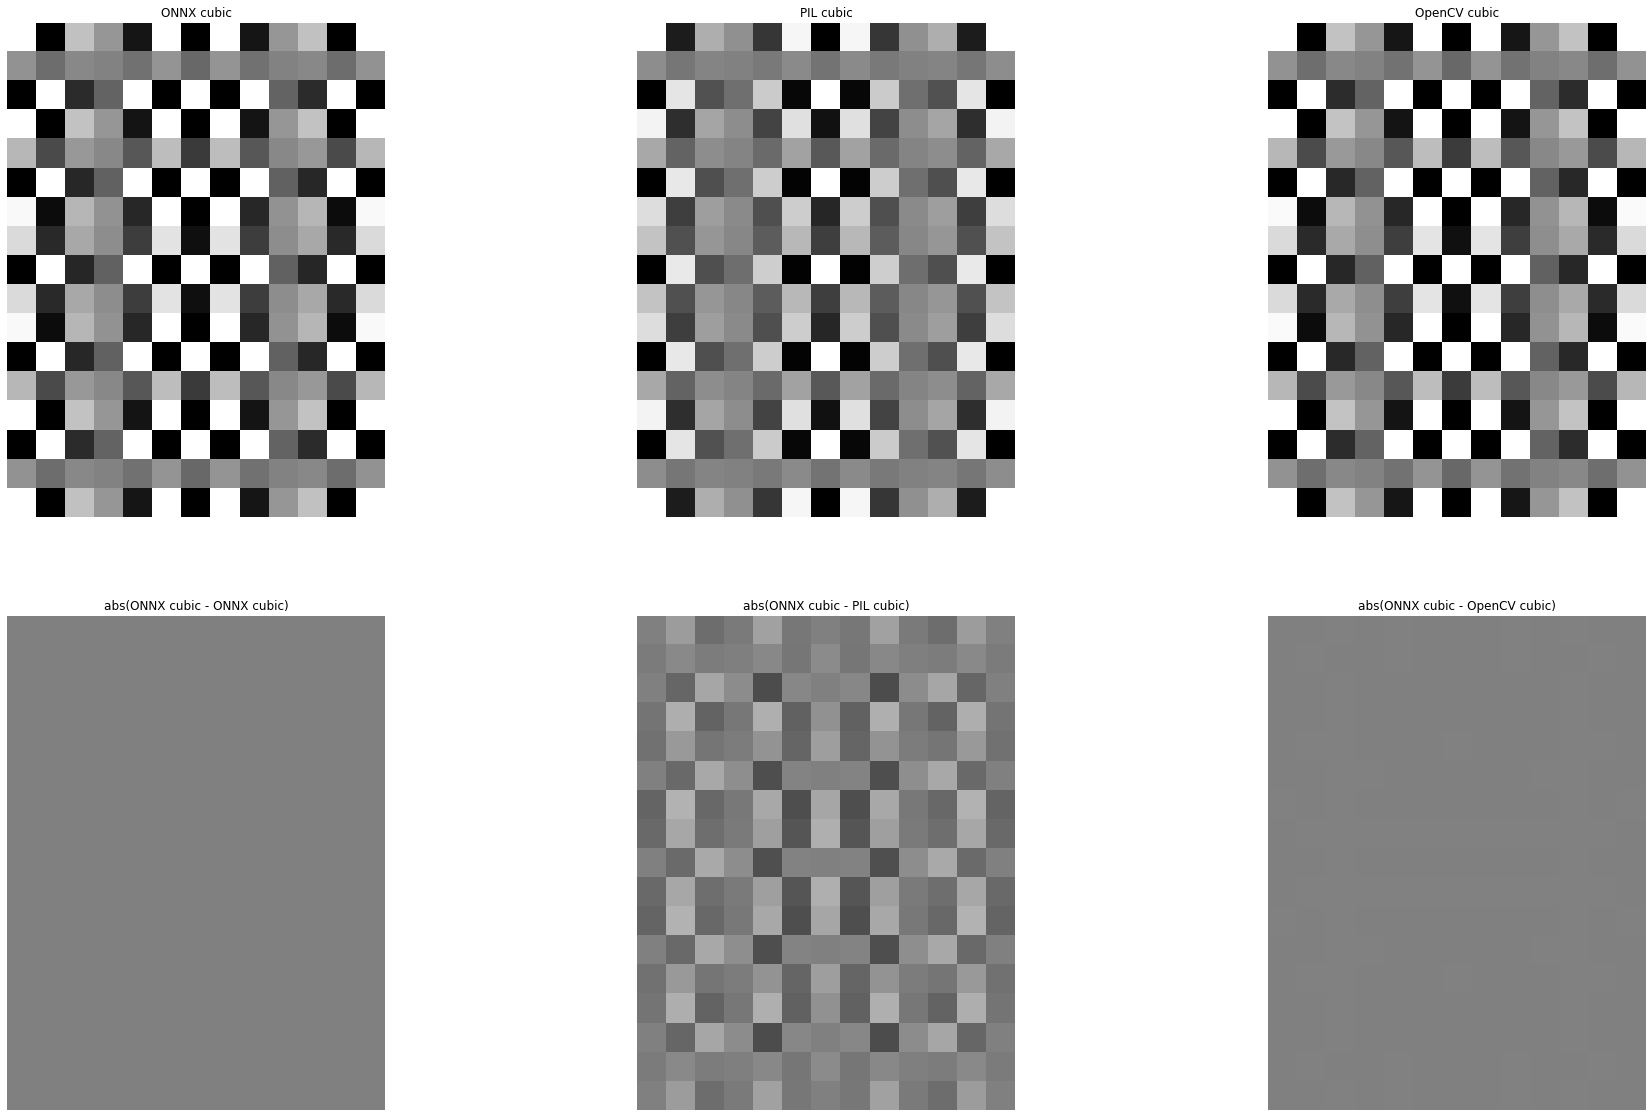

In [60]:
images = [cubic_onnx.astype(np.uint8), cubic_pil, cubic_opencv]
titles = ["ONNX cubic", "PIL cubic", "OpenCV cubic"]
diff_titles = [f"abs({titles[0]} - {t})" for t in titles]
diffs = []

b = images[0]
for a in images:
    diffs.append(diff_image(a, b))

show_images(images + diffs, titles=titles+diff_titles)

## ONNX Cubic with antialiasing vs. PIL vs. OpenCV

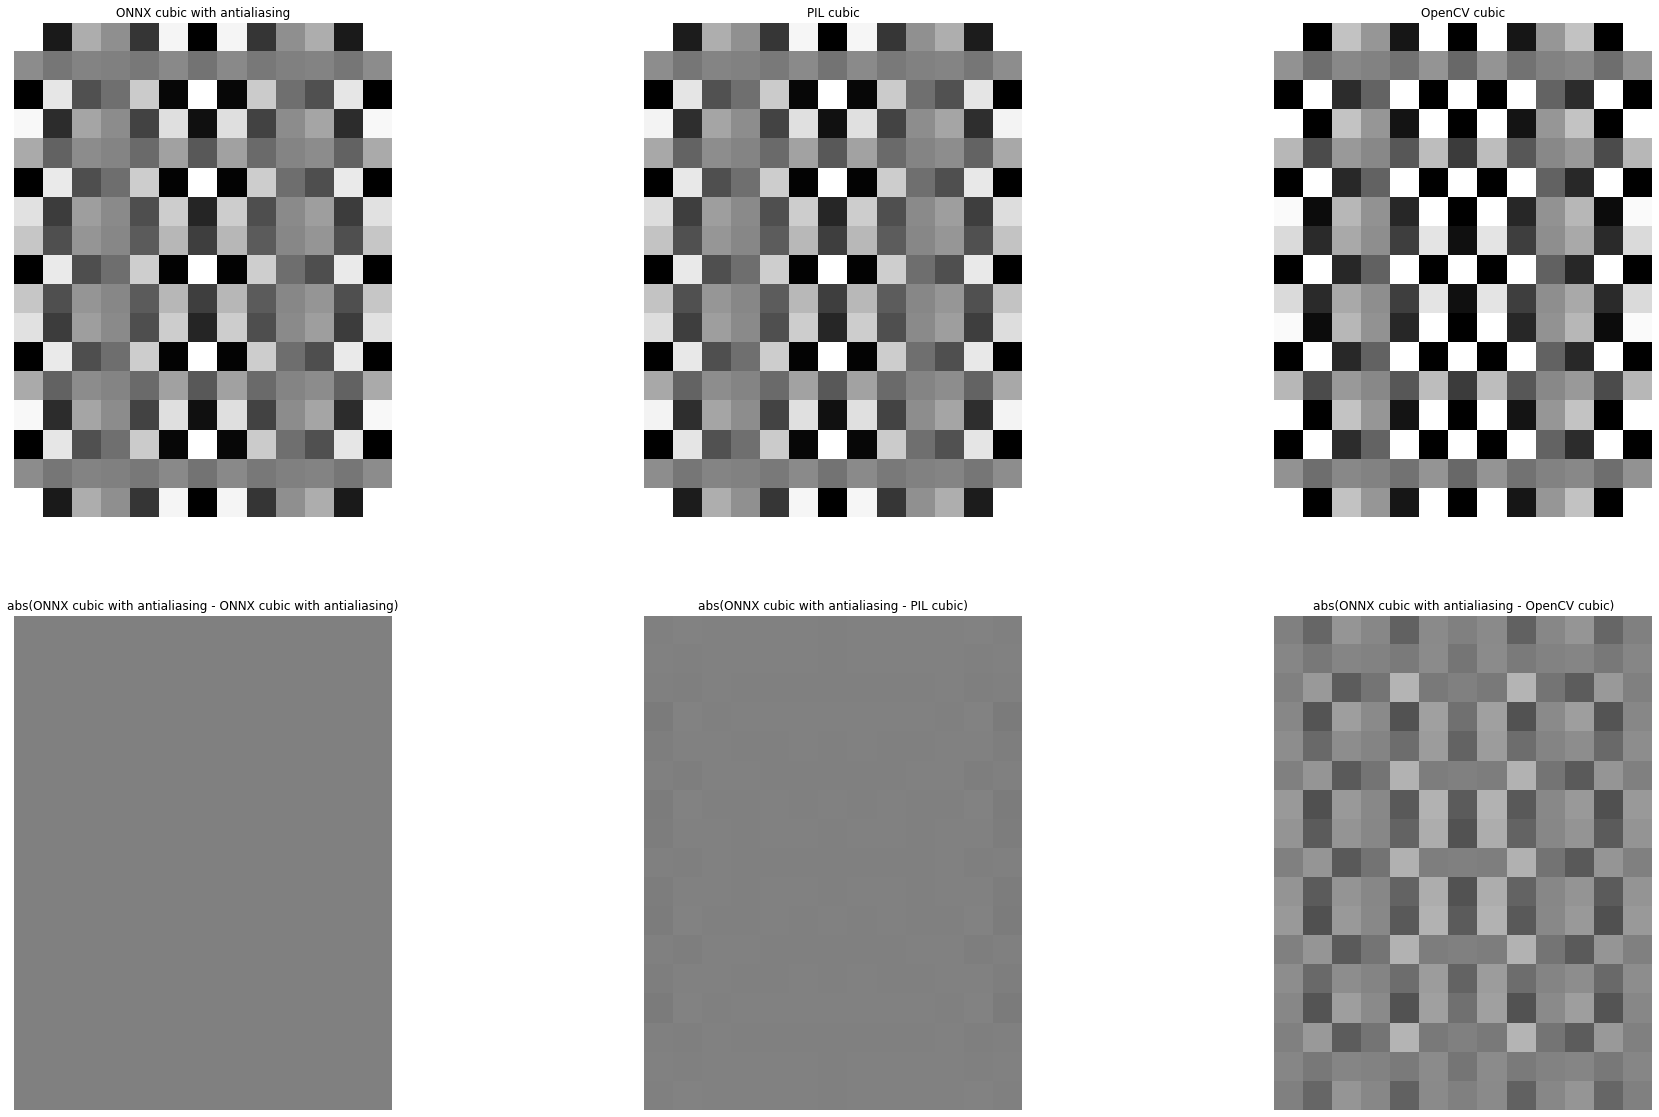

In [62]:
cubic_antialias = interpolate_nd(
    data_f, cubic_coeffs_antialias, antialias=True, scale_factors=scales).astype(np.float32)
cubic_antialias = cubic_antialias.clip(0, 255).astype(np.uint8)

images = [cubic_antialias.astype(np.uint8), cubic_pil, cubic_opencv]
titles = ["ONNX cubic with antialiasing", "PIL cubic", "OpenCV cubic"]
diff_titles = [f"abs({titles[0]} - {t})" for t in titles]
diffs = []

b = images[0]
for a in images:
    diffs.append(diff_image(a, b))

show_images(images + diffs, titles=titles+diff_titles)